In [16]:
!pip install tensorflow

  Using cached tensorflow-2.18.0-cp311-cp311-win_amd64.whl.metadata (3.3 kB)
  Using cached tensorflow_intel-2.18.0-cp311-cp311-win_amd64.whl.metadata (4.9 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached termcolor-2.5.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached grpcio-1.68.1-cp311-cp311-win_amd64.whl.metadata (4.0 kB)
  Using cached tensorboard-2.18.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached h5py-3.12.1-cp311-cp311-win_amd64.whl.metadata (2.5 kB)
  Using cached ml_dtypes-0.4.1-cp311-cp311-win_amd64.whl.metadata (20 kB)
  Using cached tensorflow_io_gcs_filesystem-0.31.0-cp311-cp311-win_amd64.whl.metadata (14 kB)
  Using cached tensorboard_data_server-0.7.2-p

In [20]:
!pip install tensorflow-datasets ipython

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/5.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/5.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/5.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/5.3 MB ? eta -:--:--
    --------------------------------------- 0.1/5.3 MB 416.7 kB/s eta 0:00:13
    --------------------------------------- 0.1/5.3 MB 476.3 kB/s eta 0:00:11
    --------------------------------------- 0.1/5.3 MB 435.7 kB/s eta 0:00:12
   - -------------------------------------- 0.1/5.3 MB 448.2 kB/s eta 0:00:12
   - -------------------------------------- 0.2/5.3 MB 535.8 kB/s eta 0:00:10
   - -------------------------------------- 0.3/5.3 MB 628.5 kB/s eta 0:00:09
   -- ------------------------------------- 0.3/5.3 MB 655.2 kB/s eta 0:00:08
   -- ------------------------------------- 0.4/5.3 MB 739.0 kB/s eta 0:00:0

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
streamlit 1.30.0 requires protobuf<5,>=3.20, but you have protobuf 5.29.2 which is incompatible.


In [1]:
import sys
sys.path.append('C:\\Users\\kirub\\examples-master\\')
from tensorflow_examples.models.pix2pix import pix2pix


In [ ]:
!pip install --upgrade ipywidgets


In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [ ]:
Download dataset from oxford iiit pet in Kaggle and import locally

In [3]:
data_dir = "C:\\Users\\kirub\\examples-master\\images\\"

In [4]:
dataset, info = tfds.load(
    name="oxford_iiit_pet",  
    data_dir=data_dir,         
    with_info=True             
)

The code below performs a simple image augmentation. Like we prepare the data before doing any machine learning task based on text analysis

In [5]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask


@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In the dataset, we already have the required number of training and test sets. So I will continue to use that split of training and test sets

In [6]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test = dataset['test'].map(load_image_test)

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

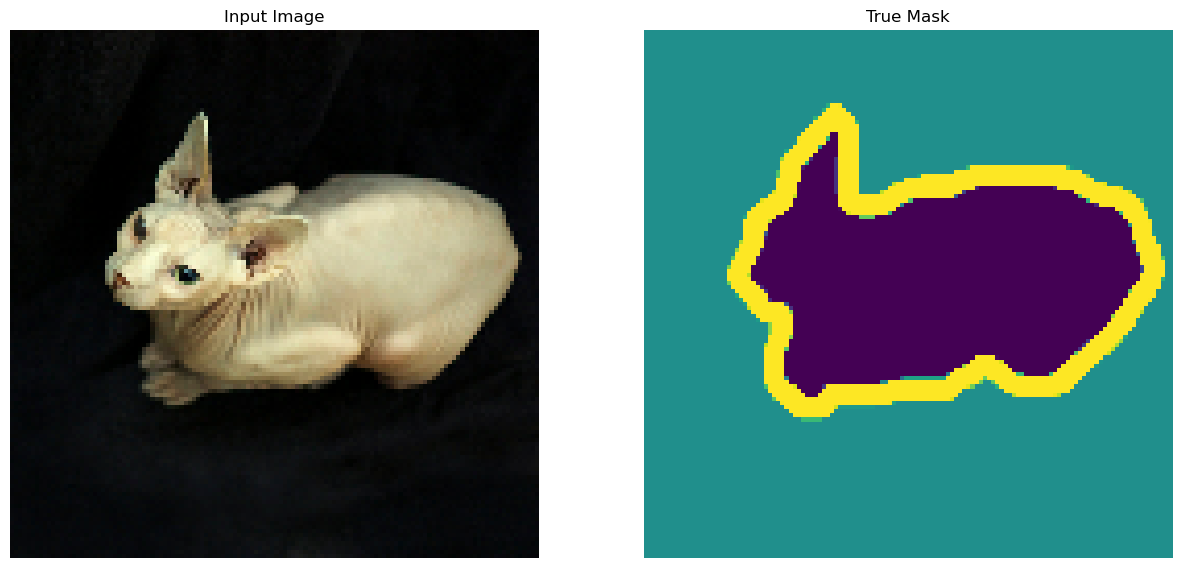

In [7]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()
  
  
for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

We are using modified U-Net. A U-Net contains an encoder and a decoder. In order to learn the robust features, and reducing all the trainable parameters, a pretrained model can be used efficiently as an encoder.

In [9]:
OUTPUT_CHANNELS = 3

our encoder is a pretrained model which is available and ready to use in tf.keras.applications. This encoder contains some specific outputs from the intermediate layers of the model. Please note that the encoder will not be trained during the process of training.

In [10]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 5s 1us/step


The decoder/upsampler is simply a series of upsample blocks implemented in TensorFlow

In [11]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]


def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

### Training the Image Segmentation Model

In [12]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [14]:
!pip install pydot

### Predicts before Training

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


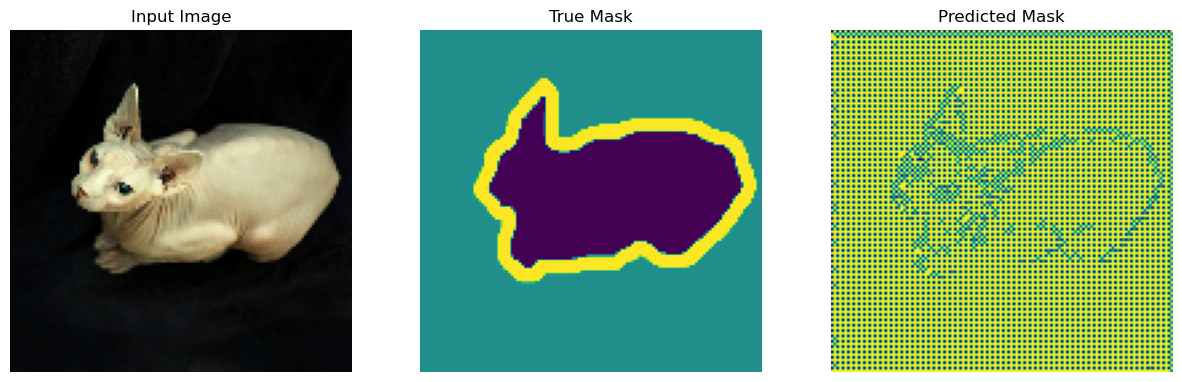

In [16]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])
show_predictions()

Let’s observe how the Image Segmentation model improves while it is training. To accomplish this task, a callback function is defined below

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


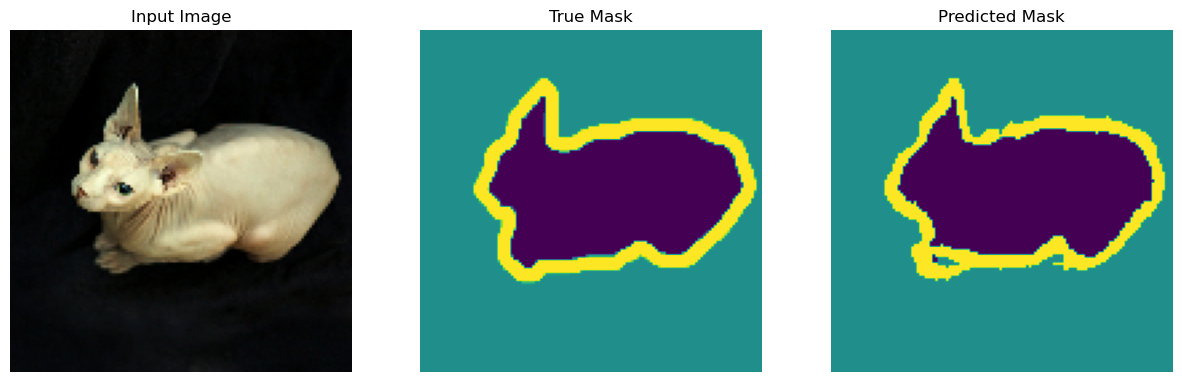


Sample Prediction after epoch 20

57/57 ━━━━━━━━━━━━━━━━━━━━ 308s 5s/step - accuracy: 0.9364 - loss: 0.1396 - val_accuracy: 0.8896 - val_loss: 0.3368


In [17]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))
    
    
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

let’s have a quick look on the performance of the model

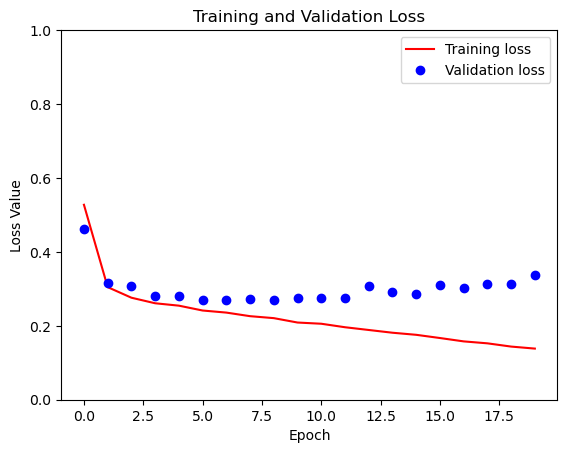

In [18]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()  

## Make Predictions using Image Segmentation

Let’s make some predictions. In the interest of saving time, the number of epochs was kept small, but you may set this higher to achieve more accurate results:

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step


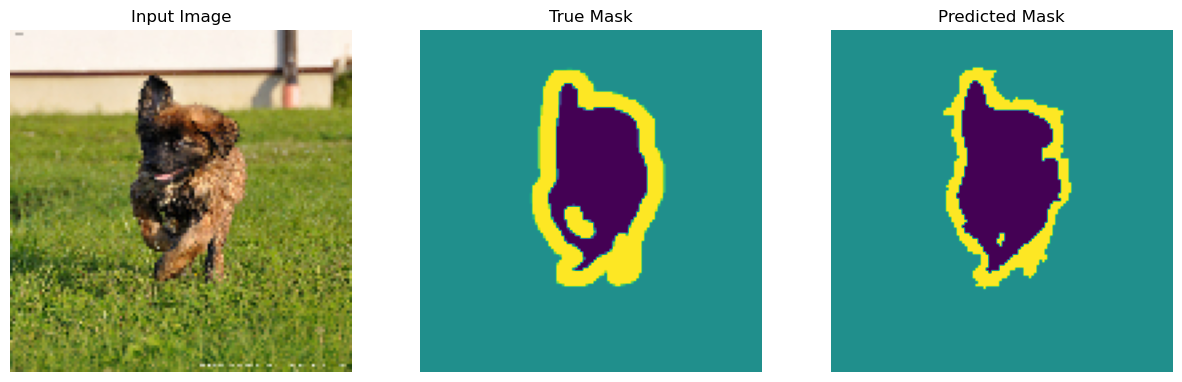

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step


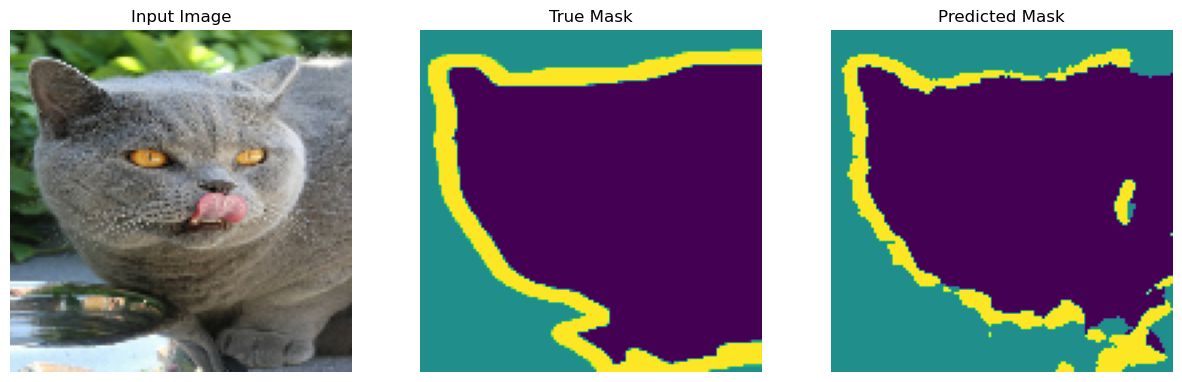

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step


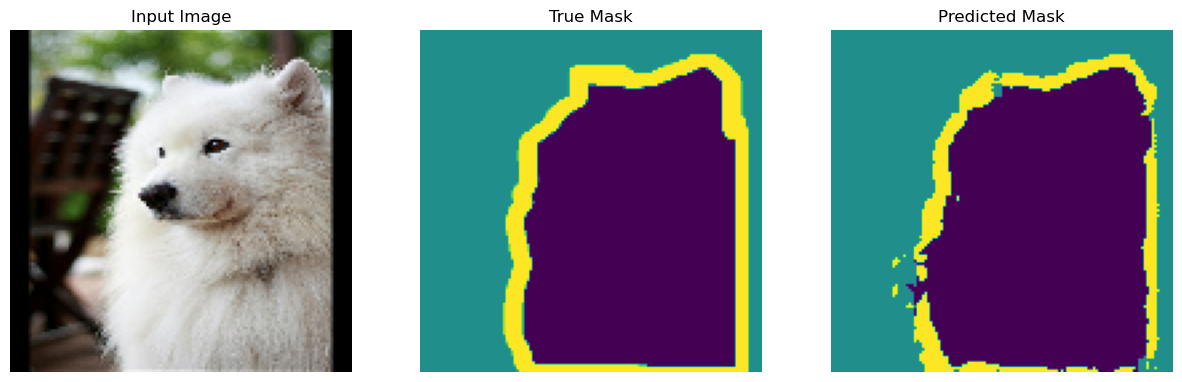

In [19]:
show_predictions(test_dataset, 3)